# Метод Годунова 

## Задача Римана

### Постановка задачи 
Рассмотрим систему уравнений газовой динамики 

$$\frac{\partial \textbf{U}}{\partial t} + \frac{\partial \textbf{F}}{\partial x} = 0$$

где 

$$
\textbf{U} = \begin{bmatrix}
    \rho \\
    \rho v \\
    e
\end{bmatrix}
$$

$$
\textbf{F} = \begin{bmatrix}
    \rho v \\
    \rho v^2 + p \\
    (e + p)v
\end{bmatrix}
$$

$$e = \frac{\rho v^2}{2} + \frac{p}{\gamma - 1}$$

с начальным условием в виде разрыва 

$$\textbf{U}(x, 0) = \begin{cases}
           \textbf{U}_L &\text{, $x < 0$}\\
           \textbf{U}_R &\text{, $x > 0$}
         \end{cases}$$

### Ход решения

Для её решения необходимо разрешить нелинейное уравнение относительно давления $p_c$ на контактном разрыве

$$f_L(p_c) + f_R(p_c) = v_L - v_R$$

где

$$
\left. f_k(p_c) \right|_{k = L, R} = \begin{cases}
           \dfrac{p_c - p_k}{\sqrt{\frac{1}{2} \rho_k [(\gamma_k + 1)p_c + (\gamma_k - 1)p_k]}} &\text{, $p_c 	\geqslant  p_k$}\\
           \dfrac{2c_k}{\gamma - 1} (\dfrac{p_c}{p_k})^{\frac{\gamma_k - 1}{2\gamma_k}} &\text{, $p_c < p_k$}
         \end{cases}
$$

Воспользуемся методом Ньютона 

$$
p_c^{(i + 1)} = p_c^{(i)} - \dfrac{f_L(p_c^{(i)}) + f_R(p_c^{(i)}) - (v_L - v_R)}{f_L'(p_c^{(i)}) + f_R'(p_c^{(i)})}
$$

с начальным приближением по звуковому распаду 

$$
p_c^{(0)} = \dfrac{p_L \rho_R c_R + p_R \rho_L c_L + (v_L - v_R) \rho_L c_L \rho_R c_R}{\rho_L c_L + \rho_R c_R}
$$

Скорость контактного разрыва $v_c$ после нахождения давления $p_c$ на нём находём как 

$$v_c = \frac{1}{2} (v_R + v_L + f_R(p_c) - f_L(p_c)$$

Далее после классификации возникающего течения можем найти параметры той части течения, куда попадает прямая $x = 0$, что необходимо для расчета численного потока через грани соседних ячеек 

In [122]:
import numpy as np
import matplotlib.pyplot as plt

In [123]:
def calc_f_and_df(p_cont, params, gamma):
    rho, v, p = params
    if p_cont >= p:
        f = (p_cont - p) / np.sqrt(0.5 * rho * ((gamma + 1) * p_cont + (gamma - 1) * p))
        df = rho * (3 * gamma * p + gamma * p_cont - p + p_cont) / np.sqrt(2) / (rho * ((gamma - 1) * p + (gamma + 1) * p_cont))**1.5
    else:
        c = np.sqrt(gamma * p / rho)
        f = 2 * c / (gamma - 1) * ((p_cont / p)**((gamma - 1) / (2 * gamma)) - 1)
        df = c * (p_cont / p)**((gamma - 1) / (2 * gamma)) / (gamma * p_cont)
    return (f, df)

def calc_contact_pressure_initial_guess(params_L, params_R, gamma):
    rho_L, v_L, p_L = params_L
    rho_R, v_R, p_R = params_R
    c_L = np.sqrt(gamma * p_L / rho_L)
    c_R = np.sqrt(gamma * p_R / rho_R)
    return (p_L * rho_R * c_R + p_R * rho_L * c_L + (v_L - v_R) * rho_L * c_L * rho_R * c_R) / (rho_L * c_L + rho_R * c_R)

def calc_contact_pressure_and_velocity(params_L, params_R, gamma):
    rho_L, v_L, p_L = params_L
    rho_R, v_R, p_R = params_R
    c_L = np.sqrt(gamma * p_L / rho_L)
    c_R = np.sqrt(gamma * p_R / rho_R)
    p_cont_curr = calc_contact_pressure_initial_guess(params_L, params_R, gamma)
    MAX_ITER = 100
    iter_num = 0
    TOL = 1e-6
    eps = np.inf
    while(eps > TOL):
        if p_cont_curr <= 0:
            raise Exception('pressure is non positive')
        if iter_num > MAX_ITER:
            raise Exception('number of iterations exceeds the maximum value')
        f_L, df_L = calc_f_and_df(p_cont_curr, params_L, gamma)
        f_R, df_R = calc_f_and_df(p_cont_curr, params_R, gamma)
        p_cont_next = p_cont_curr - (f_L + f_R - (v_L - v_R)) / (df_L + df_R)
        eps = np.abs(p_cont_next - p_cont_curr)
        p_cont_curr = p_cont_next
        iter_num += 1
    v_cont = 0.5 * (v_L + v_R + f_R - f_L)
    return (v_cont, p_cont_curr)

def sample_solution(params_L, params_R, gamma):
    rho_L, v_L, p_L = params_L
    rho_R, v_R, p_R = params_R
    c_L = np.sqrt(gamma * p_L / rho_L)
    c_R = np.sqrt(gamma * p_R / rho_R)
    gamma_ratio_0 = 1 / gamma
    gamma_ratio_1 = (gamma - 1) / (2 * gamma)
    gamma_ratio_2 = (gamma + 1) / (2 * gamma)
    gamma_ratio_3 = 2 * gamma / (gamma - 1);
    gamma_ratio_4 = 2 / (gamma - 1);
    gamma_ratio_5 = 2 / (gamma + 1);
    gamma_ratio_6 = (gamma - 1) / (gamma + 1);
    gamma_ratio_7 = (gamma - 1) / 2;
    v_cont, p_cont = calc_contact_pressure_and_velocity(params_L, params_R, gamma)
    p_ratio_L = p_cont / p_L
    p_ratio_R = p_cont / p_R
    if v_cont >= 0:
        if p_cont <= p_L:
            S_head_L = v_L - c_L
            S_tail_L = v_cont - c_L * p_ratio_L**gamma_ratio_1
            if S_head_L >= 0:
                rho = rho_L
                v = v_L
                p = p_L
            else:
                if S_tail_L <= 0:
                    rho = rho_L * p_ratio_L**gamma_ratio_0
                    v = v_cont
                    p = p_cont
                else:
                    v = gamma_ratio_5 * (c_L + gamma_ratio_7 * v_L)
                    c = v
                    c_ratio = c / c_L
                    rho = rho_L * c_ratio**gamma_ratio_4
                    p = p_L * (c / c_L)**gamma_ratio_3
        else: 
            S_shock_L = v_L - c_L * np.sqrt(gamma_ratio_2 * p_ratio_L + gamma_ratio_1)
            if (S_shock_L >= 0):
                rho = rho_L
                v = v_L
                p = p_L
            else:
                rho = rho_L * (p_ratio_L + gamma_ratio_6) / (p_ratio_L * gamma_ratio_6 + 1)
                v = v_cont
                p = p_cont
    else:
        if p_cont > p_R:
            S_shock_R = v_R + c_R * np.sqrt(gamma_ratio_2 * p_ratio_R + gamma_ratio_1)
            if (S_shock_R <= 0):
                rho = rho_R
                v = v_R
                p = p_R
            else:
                rho = rho_R * (p_ratio_R + gamma_ratio_6) / (p_ratio_R * gamma_ratio_6 + 1)
                v = v_cont
                p = p_cont
        else:
            S_head_R = v_R + c_R
            S_tail_R = v_cont + c_R * p_ratio_R**gamma_ratio_1
            if S_head_R <= 0:
                rho = rho_R
                v = v_R
                p = p_R
            else:
                if S_tail_R >= 0:
                    rho = rho_R * p_ratio_R**gamma_ratio_0
                    v = v_cont
                    p = p_cont
                else:
                    v = gamma_ratio_5 * (- c_R + gamma_ratio_7 * v_R)
                    c = gamma_ratio_5 * (c_R - gamma_ratio_7 * v_R)
                    c_ratio = c / c_R
                    rho = rho_R *  c_ratio** gamma_ratio_4
                    p = p_R *  c_ratio** gamma_ratio_3
    return (rho, v, p)

def godunov_flux(params_L, params_R, gamma):
    rho_L, v_L, p_L = params_L
    rho_R, v_R, p_R = params_R
    c_L = np.sqrt(gamma * p_L / rho_L)
    c_R = np.sqrt(gamma * p_R / rho_R)
    rho, v, p = sample_solution(params_L, params_R, gamma)
    e = rho * v**2 / 2 + p / (gamma - 1)
    return np.array([rho * v, rho * v**2 + p, (e + p) * v])

In [124]:
def prim_params_to_cons_params(prim_params, gamma):
    rho, v, p = prim_params
    e = rho * v**2 / 2 + p / (gamma - 1)
    return (rho, rho * v, e)
def cons_params_to_prim_params(cons_params, gamma):
    rho, rho_v, e = cons_params
    v = rho_v / rho
    p = (e - rho * v**2 / 2) * (gamma - 1)
    return (rho, v, p)

In [125]:
def initaial_condition(init_params_L, init_params_R, x_0, L, H):
    DIM = 3
    M = int(L / H) + 1 
    gamma = 1.4
    U_init = np.zeros((M, DIM))
    for m in range(M):
        if m * H < x_0:
            U_init[m] = prim_params_to_cons_params(init_params_L, gamma)
        else:
            U_init[m] = prim_params_to_cons_params(init_params_R, gamma)
    return U_init
    
def godunov_solver(init_params_L, init_params_R, x_0, L, H, T, TAU):
    DIM = 3
    U = np.zeros((N, M, DIM))
    U[0] = initaial_condition(init_params_L, init_params_R, x_0, L, H)
    for n in range(N - 1):
        for m in range(M):
            if m != 0:
                flux_left = godunov_flux(cons_params_to_prim_params(U[n, m - 1], gamma), cons_params_to_prim_params(U[n, m], gamma), gamma)
            else:
                flux_left = godunov_flux(cons_params_to_prim_params(U[n, 0], gamma), cons_params_to_prim_params(U[n, 0], gamma), gamma) 
            if m != M - 1:
                flux_right = godunov_flux(cons_params_to_prim_params(U[n, m], gamma), cons_params_to_prim_params(U[n, m + 1], gamma), gamma)
            else:
                flux_right = godunov_flux(cons_params_to_prim_params(U[n, M - 1], gamma), cons_params_to_prim_params(U[n, M - 1], gamma), gamma)
            U[n + 1, m] = U[n, m] - TAU / H * (flux_right - flux_left)
    return U

In [111]:
L = 1
H = 1e-2
M = int(L / H) + 1
x_grid = np.linspace(0, L, M)

T = 0.2
TAU = 1e-4
N = int(T / TAU)

gamma = 1.4

DIM = 3

x_0 = 0.3

# rho, v, p
init_params_L = (1.0, 0.75, 1.0)
init_params_R = (0.125, 0.0, 0.1)

U = np.zeros((N, M, DIM))
U = godunov_solver(init_params_L, init_params_R, x_0, L, H, T, TAU)

U_prim_params = np.zeros((M, 3))
for m in range(M):
    U_prim_params[m] = cons_params_to_prim_params(U[N - 1, m, :], gamma)

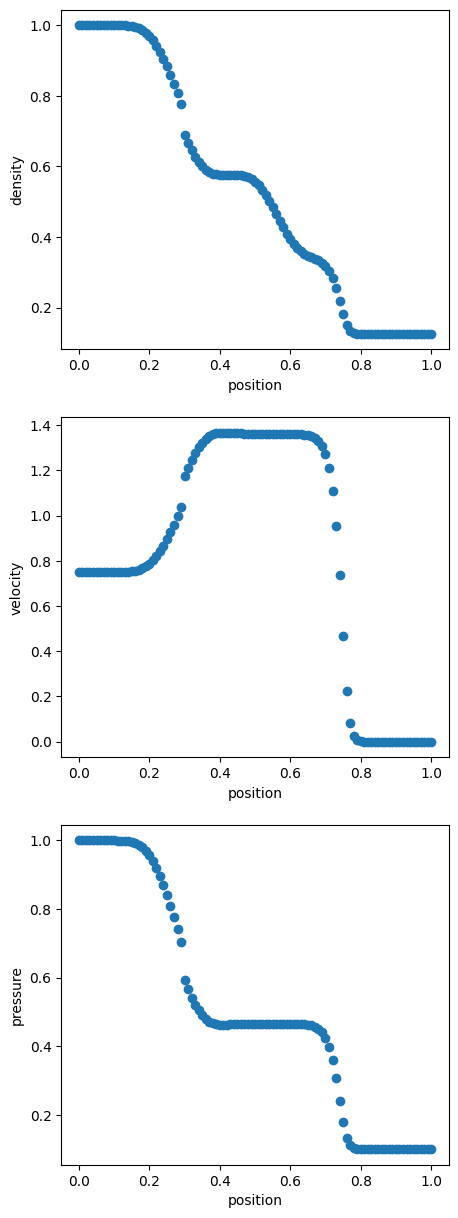

In [112]:
fig, ax = plt.subplots(3, 1, figsize=(5, 15))

ax[0].scatter(x_grid, U_prim_params[:, 0])
ax[0].set_xlabel('position')
ax[0].set_ylabel('density')

ax[1].scatter(x_grid, U_prim_params[:, 1])
ax[1].set_xlabel('position')
ax[1].set_ylabel('velocity')
           
ax[2].scatter(x_grid, U_prim_params[:, 2])
ax[2].set_xlabel('position')
ax[2].set_ylabel('pressure')

plt.show()

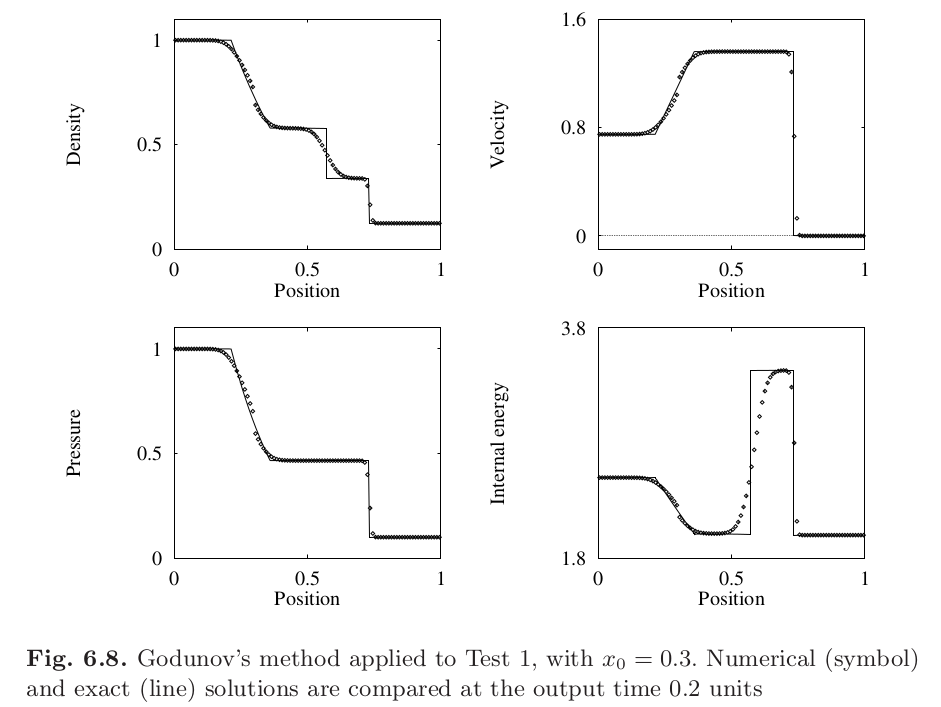

In [114]:
from IPython.display import Image
Image(filename = "test_1.png", width=600)

In [116]:
L = 1
H = 1e-2
M = int(L / H) + 1
x_grid = np.linspace(0, L, M)

T = 0.035
TAU = 1e-5
N = int(T / TAU)

gamma = 1.4

DIM = 3

x_0 = 0.4

# rho, v, p
init_params_L = (5.99924, 19.5975, 460.894)
init_params_R = (5.99242, -6.19633, 46.0950)

U = np.zeros((N, M, DIM))
U = godunov_solver(init_params_L, init_params_R, x_0, L, H, T, TAU)

U_prim_params = np.zeros((M, 3))
for m in range(M):
    U_prim_params[m] = cons_params_to_prim_params(U[N - 1, m, :], gamma)

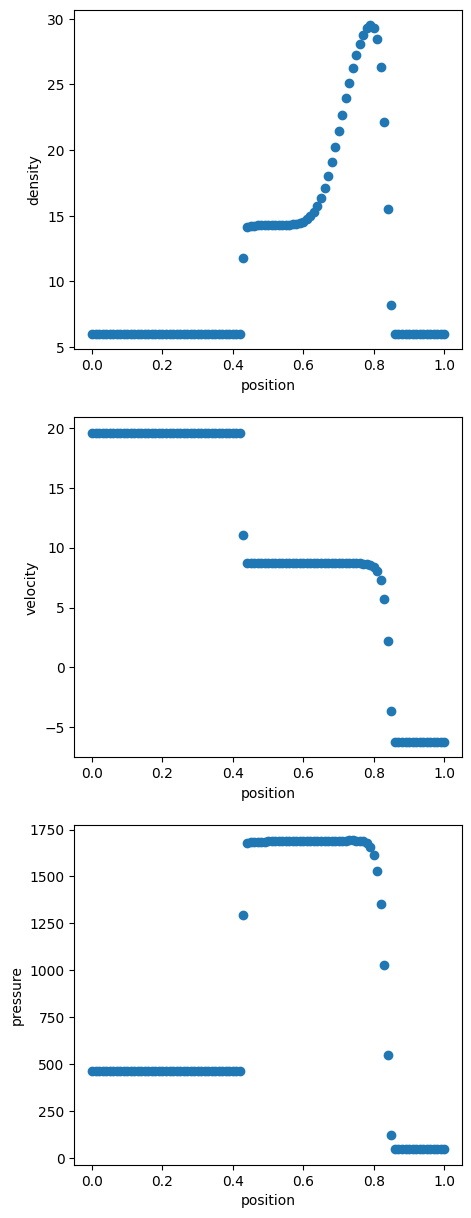

In [117]:
fig, ax = plt.subplots(3, 1, figsize=(5, 15))

ax[0].scatter(x_grid, U_prim_params[:, 0])
ax[0].set_xlabel('position')
ax[0].set_ylabel('density')

ax[1].scatter(x_grid, U_prim_params[:, 1])
ax[1].set_xlabel('position')
ax[1].set_ylabel('velocity')
           
ax[2].scatter(x_grid, U_prim_params[:, 2])
ax[2].set_xlabel('position')
ax[2].set_ylabel('pressure')

plt.show()

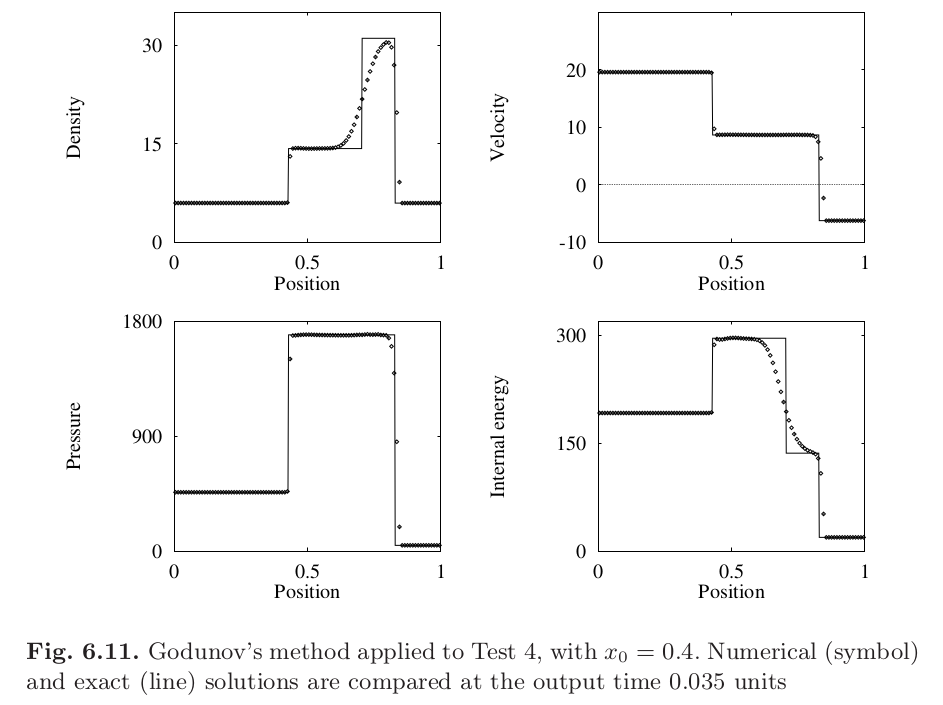

In [118]:
from IPython.display import Image
Image(filename = "test_2.png", width=600)

In [119]:
L = 1
H = 1e-2
M = int(L / H) + 1
x_grid = np.linspace(0, L, M)

T = 0.012
TAU = 1e-5
N = int(T / TAU)

gamma = 1.4

DIM = 3

x_0 = 0.8

# rho, v, p
init_params_L = (1.0, -19.59745, 1000.0)
init_params_R = (1.0, -19.59745, 0.01)

U = np.zeros((N, M, DIM))
U = godunov_solver(init_params_L, init_params_R, x_0, L, H, T, TAU)

U_prim_params = np.zeros((M, 3))
for m in range(M):
    U_prim_params[m] = cons_params_to_prim_params(U[N - 1, m, :], gamma)

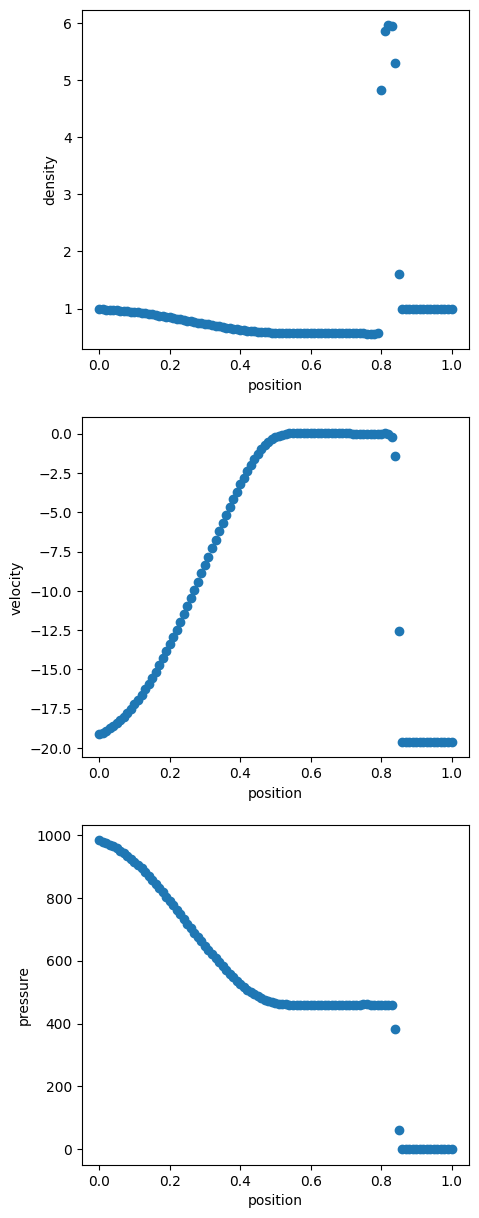

In [120]:
fig, ax = plt.subplots(3, 1, figsize=(5, 15))

ax[0].scatter(x_grid, U_prim_params[:, 0])
ax[0].set_xlabel('position')
ax[0].set_ylabel('density')

ax[1].scatter(x_grid, U_prim_params[:, 1])
ax[1].set_xlabel('position')
ax[1].set_ylabel('velocity')
           
ax[2].scatter(x_grid, U_prim_params[:, 2])
ax[2].set_xlabel('position')
ax[2].set_ylabel('pressure')

plt.show()

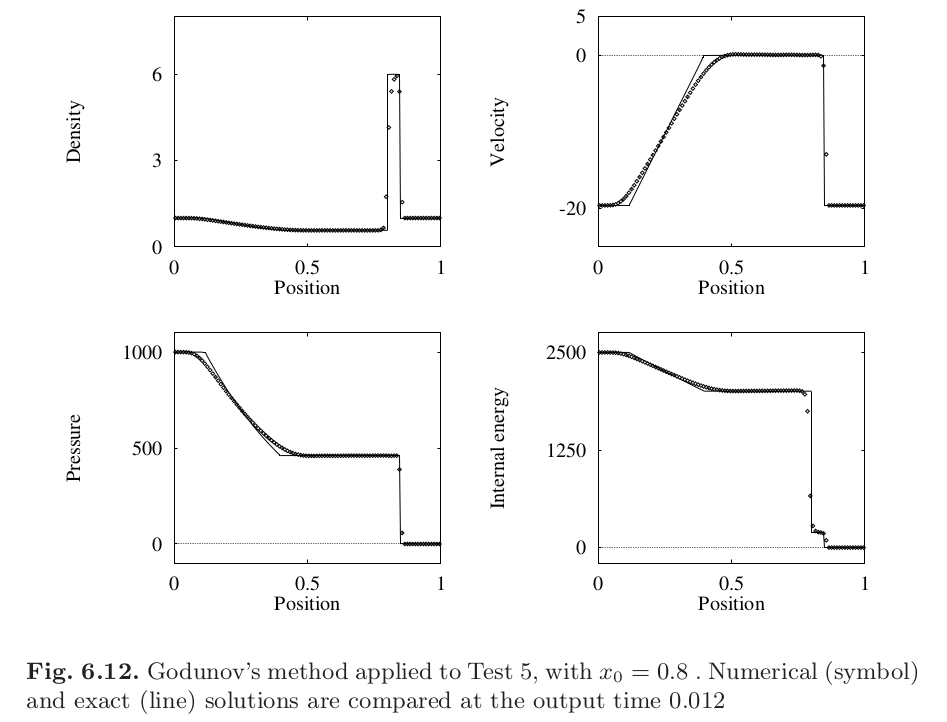

In [121]:
from IPython.display import Image
Image(filename = "test_3.png", width=600)